In [19]:
import pandas as pd
import numpy as np
import pickle
import re
from tqdm import tqdm
import seaborn as sns
#from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from glob import glob
from collections import defaultdict
import scipy

In [20]:
sns.set_theme()
sns.set_context("talk", font_scale=1.7)#, rc={"font.size": 7})
sns.set_style(style={'xtick.bottom': True,'ytick.left': True, 'axes.edgecolor': 'black'})

In [21]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/motif_predictions/split_75_25/'

In [22]:
test_df = pd.read_csv(data_dir + 'test.csv').set_index('seq_name').squeeze()

In [23]:
motif_len = 5 #5 or 6

In [24]:
table_motifs = pd.read_csv(data_dir + f'../motifs_k{motif_len}.csv')
table_motifs.loc[table_motifs.protein.isna(), 'protein'] = 'Random' 

In [25]:
models = {'Dinucl.':'dinucl','11-mer':'11_mer','Species-agnostic':'../species_agnostic/probas',
          'Species-aware':'../species_aware/probas', 'DNABERT': 'dnabert/default/'}

#models = {'Dinucl.':'dinucl','11-mer':'11_mer','Species-agnostic':'../species_agnostic_tempscale/probas',
#          'Species-aware':'../species_aware_tempscale/probas', 'DNABERT': 'dnabert/default/'}

In [26]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [27]:
def get_dnabert(res_path):
    res = {}
    for probas_file in glob(res_path + 'preds*.npy'):
        seq_matching = pd.read_csv(probas_file.replace('/preds','/seq').replace('.npy','.csv')).set_index('seq_name').squeeze()
        probas = np.load(probas_file)
        s = 0
        for seq_name, seq in seq_matching.items():
            res[seq_name] = [x[mapping[seq[seq_idx]]] for seq_idx,x in enumerate(probas[s:s+len(seq),:])]
            s += len(seq)
        assert s==len(probas)
    return res

In [28]:
def get_dnabert_tscale(res_path, temperature = 9486):
    #use temp_scale_dnabert for calibration
    res_t_scale = {} #calibrated probas
    res = {} #uncalibrated softmax probas
    for probas_file in glob(res_path + 'logits*.npy'):
        seq_matching = pd.read_csv(probas_file.replace('/logits_','/seq_').replace('.npy','.csv')).set_index('seq_name').squeeze()
        logits = np.load(probas_file)
        probas_t_scale = scipy.special.softmax(logits / temperature,axis=1) 
        probas = scipy.special.softmax(logits,axis=1) 
        s = 0
        for seq_name, seq in seq_matching.items():
            #res[seq_name] = [x[mapping[seq[seq_idx]]] for seq_idx,x in enumerate(probas[s:s+len(seq),:])]
            res[seq_name] = probas[s:s+len(seq),:]
            res_t_scale[seq_name] = probas_t_scale[s:s+len(seq),:]
            s += len(seq)
        assert s==len(probas)
    return res, res_t_scale

In [29]:
res = {}

for model, model_path in models.items():
    if model!='DNABERT':
        with open(data_dir + model_path + '.pickle','rb') as f:
            res[model] = dict(pickle.load(f))
    else:
        res[model] = get_dnabert(data_dir + model_path)
        #_,res[model] = get_dnabert_tscale(data_dir + model_path)

In [30]:
motifs_df = []

for seq_name,seq in tqdm(test_df.items(), total=len(test_df)):
    #if not seq_name in res['DNABERT']:
    #    continue
    for protein, motif in table_motifs.set_index('protein').squeeze().items():
        label = f'{protein}\n{motif}' if protein!='Random' else 'Random'
        motif_mapping = [list(range(len(motif))),list(map(lambda x:mapping[x],motif))]
        for match in re.finditer(motif,seq):
            for model in models:
                if 'Species' in model:
                    avg_target_prob = np.mean(res[model][seq_name][match.start():match.end()][motif_mapping[0], motif_mapping[1]])
                else:
                    avg_target_prob = np.mean(res[model][seq_name][match.start():match.end()])
                motifs_df.append((model,seq_name,match.start(),label,motif,avg_target_prob))

100%|██████████| 4534/4534 [05:47<00:00, 13.03it/s]


In [31]:
motifs_df = pd.DataFrame(motifs_df,columns = ['model','seq_name','motif_start','label','motif','avg_target_prob'])

In [32]:
selected_proteins = ['HNRNPL', 'TIA1', 'KHDRBS2', 'PCBP2', 'TRA2A', 'FUS', 'PUM1']

In [33]:
selected_motifs = table_motifs[table_motifs.protein.isin(selected_proteins)].drop_duplicates(subset='protein',keep='first')
#selected_motifs = pd.concat([table_motifs[table_motifs.protein=='Random'],selected_motifs]) #add random motifs
selected_motifs = selected_motifs.set_index('protein').squeeze() #convert to series

In [34]:
selected_labels = ['Random'] + (selected_motifs.index + '\n' + selected_motifs).tolist()

/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-python/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

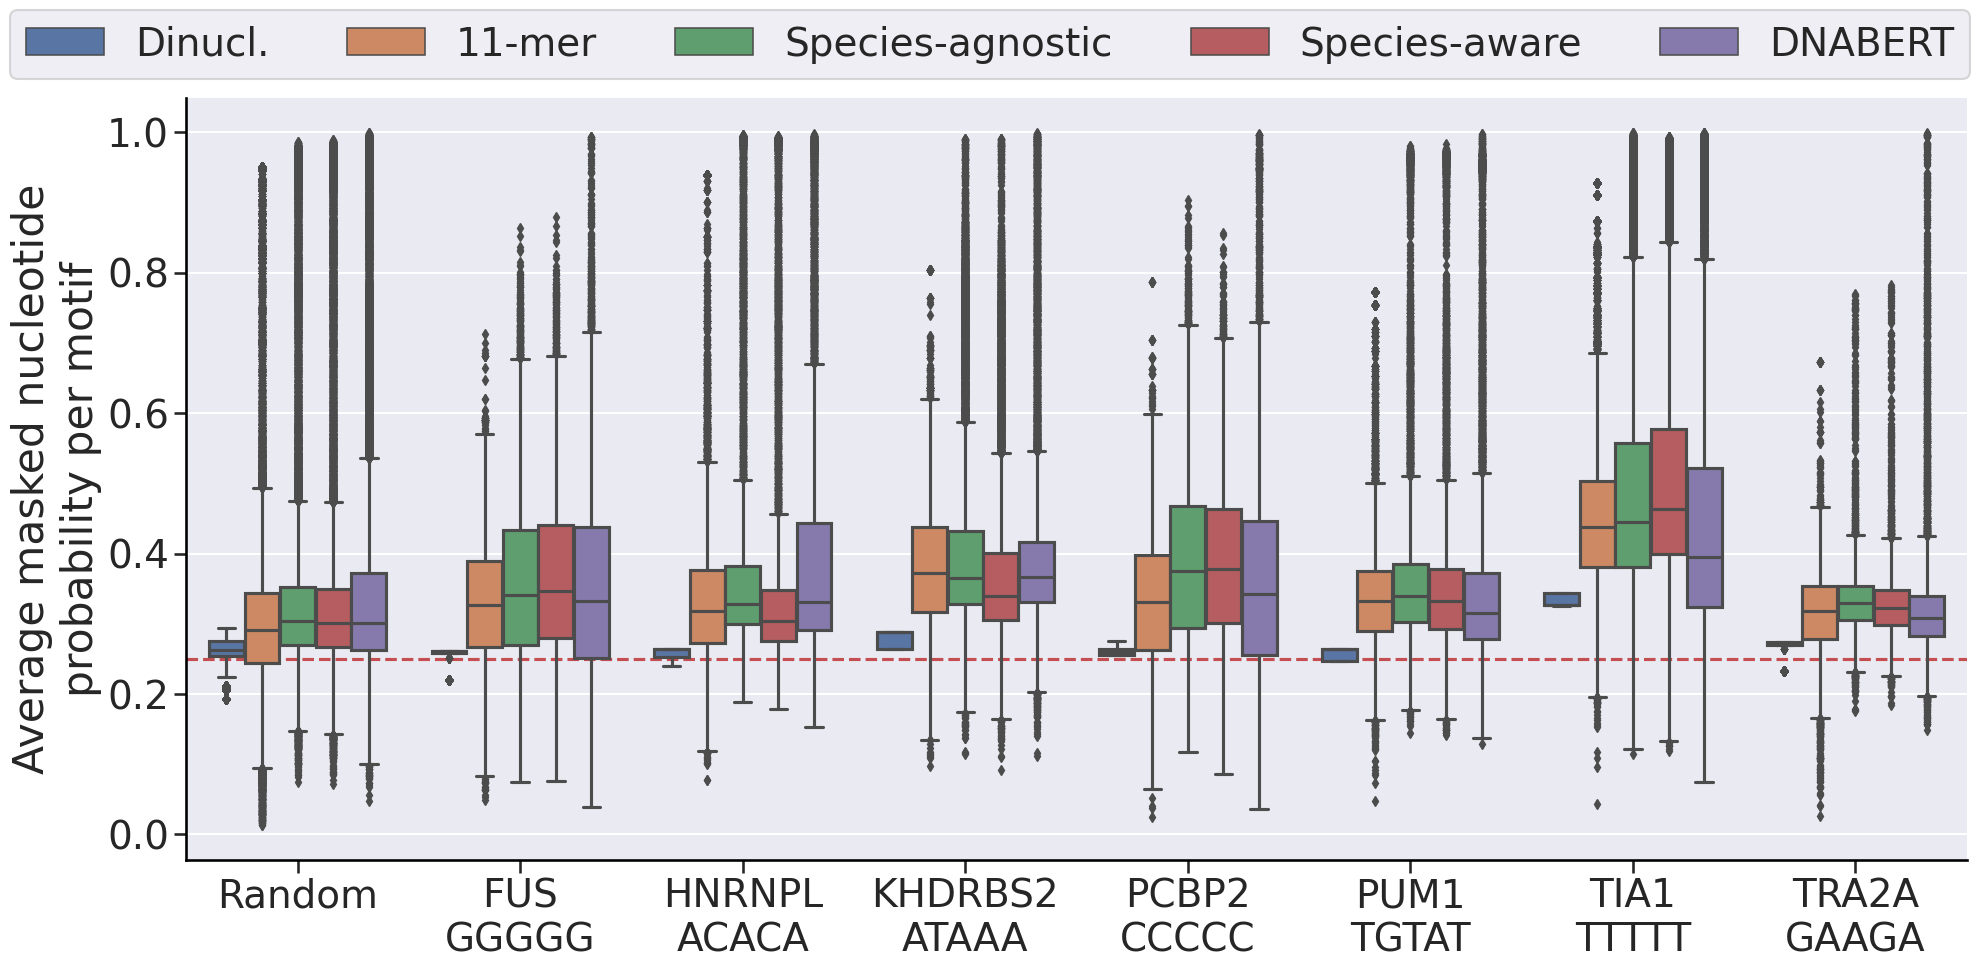

In [35]:
plt.clf()


sns.catplot(data=motifs_df[motifs_df.label.isin(selected_labels)], x="label", y="avg_target_prob", hue="model",
                kind="box", height=10, aspect=2.0, estimator=np.mean, order=selected_labels,zorder=3, legend=False)#, palette=custom_colors)

#plt.xticks(rotation = 45, ticks = range(0,8),labels=motifs_df.label.unique())

plt.axhline(0.25,color="r", zorder=-1, linestyle='--');

plt.legend(loc='lower left', ncols=5, bbox_to_anchor=(-0.11, 1))
plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif")
plt.show()

In [34]:
avg_probas_df = motifs_df.groupby(['motif','model']).avg_target_prob.mean().reset_index()

In [35]:
avg_probas_df = pd.pivot_table(avg_probas_df, index='motif', columns=['model'], values='avg_target_prob')

In [36]:
#avg_probas_df.drop(columns='best_model', inplace=True)

In [37]:
avg_probas_df['best_model'] = avg_probas_df.apply(lambda x: x.sort_values().index[-1],axis=1)

In [23]:
avg_probas_df.best_model.value_counts()

best_model
DNABERT             403
Species-aware        63
Species-agnostic     40
Dinucl.               5
11-mer                1
Name: count, dtype: int64

In [52]:
df = avg_probas_df[['DNABERT','Species-aware']].copy()
df['best_model'] = df.apply(lambda x: x.sort_values().index[-1],axis=1)

In [56]:
conservation_df = pd.read_csv(data_dir + f'../species_aware/conservation_k{motif_len}.csv.gz')

In [57]:
N_species = 241

conservation_score = conservation_df.groupby('motif')['Nmatches_200'].mean().rename('consv_score')/N_species

In [58]:
df = pd.concat([df,conservation_score],axis=1)

In [59]:
from scipy import stats

In [60]:
stats.ttest_ind(*df.groupby('best_model').consv_score.apply(list).tolist())[1]

6.565915846237196e-08

In [61]:
df.groupby('best_model').consv_score.mean()

best_model
DNABERT          0.302830
Species-aware    0.373424
Name: consv_score, dtype: float64

In [62]:
df.groupby('best_model').size()

best_model
DNABERT          428
Species-aware     84
dtype: int64